In [58]:
import aerosol_module as am # This is a module that I wrote for this class
import numpy as np
import pandas as pd
from scipy import constants as const
from pyfluids import Fluid, FluidsList, Input
import matplotlib.pyplot as plt
from icecream import ic

In [59]:
# For testing the module functions
if __name__ == '__main__': # This is to test the module functions
    print("This is a module that contains the functions that are could be useful for my projects")


# importing libraries

This is a module that contains the functions that are could be useful for my projects


In [60]:
import numpy as np
from pyfluids import Fluid, FluidsList, Input
from scipy import constants as const
import pandas as pd


# Global constants

In [61]:
h = const.Planck  # J s Planck constant
r_gas_c = const.R  # J/(mol K) molar gas constant 
k_Boltzmann = const.Boltzmann  # J/K Boltzmann constant
g = const.g  # m/s^2 acceleration due to gravity
n_avo = const.Avogadro  # 1/mol Avogadro's number


# Default air standard properties

In [62]:
pressure_std = 101325  # Pa
temperature_std = 273.15 + 25  # K #??????? need to make sure this is the right temperature
air_std = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temperature_std - 273.15))


# Functions

In [63]:


def c_cunningham(d_p, lamda=65E-9):
    # defining the function
    # Cunningham correction factor
    # Dp is the particle diameter in meters
    # lamda is the mean free path of the gas in meters
    # C is the Cunningham correction factor
    kn = 2 * lamda / d_p
    return 1 + kn * (1.257 + 0.4 * np.exp(-1.1 / kn))


In [64]:


def mean_free_path(temperature: float, pressure: float):
    # mean free path of air calculator
    # T is the temperature in Kelvin
    # P is the pressure in Pascals
    # lamda is the mean free path of the gas in meters
    R = 8.314  # J/(mol K) gas constant
    M = 0.0289647  # kg/mol molar mass of air
    air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
    viscosity = air.dynamic_viscosity  # Pa s dynamic viscosity
    return 2 * viscosity / (pressure * np.sqrt(8 * M / (np.pi * R * temperature)))


In [65]:


def reynolds_number(d_p: float, velocity: float, fluid_density=air_std.density, 
                    dynamic_viscosity=air_std.dynamic_viscosity):
    # Reynolds number calculator
    # Dp is the particle diameter in meters
    # rho_f is the density of the fluid in kg/m^3
    # g is the acceleration due to gravity in m/s^2
    # C is the Cunningham correction factor
    # Re is the Reynolds number
    return (d_p * fluid_density * velocity) / dynamic_viscosity


In [66]:


def settling_velocity(d_p, rho_p: float, temperature: float, pressure: float):
    # Check if Dp_input is an array or a single value
    if np.isscalar(d_p):
        d_p_array = np.array([d_p])  # Convert to array for uniform processing
    else:
        d_p_array = d_p  # Use the array as is

    velocities = []  # Empty list to store calculated velocities
    for d_p in d_p_array:  # Process each Dp individually
        g = 9.81  # m/s^2
        l_mfp = mean_free_path(temperature, pressure)
        c_cun = c_cunningham(d_p, l_mfp)
        air = Fluid(FluidsList.Air).with_state(Input.pressure(pressure), Input.temperature(temperature - 273.15))
        mu_f = air.dynamic_viscosity
        rho_f = air.density
        s_velocity = c_cun * (rho_p * g * d_p ** 2) / (18 * mu_f)  # Stokes settling velocity
        Re = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
        if Re < 1:
            velocities.append(s_velocity)
        else:
            # Adjusted iterative approach for Re > 1, similar to before
            m_p = np.pi * rho_p * d_p ** 3 / 6
            for i in range(100):
                # c_d = 24 / Re * (1 + 0.15 * Re**(0.687))  # Updated drag coefficient expression
                c_d = 24 / Re * (1 + 3 / 16 * 0.43 * Re)
                # s_velocity = np.sqrt((4 * m_p * g) / (3 * np.pi * c_d * rho_f * Dp**2))
                s_velocity = np.sqrt((m_p * g) / (1 / 8 * np.pi * c_d * rho_f * d_p ** 2))
                Re_new = reynolds_number(d_p, s_velocity, fluid_density=rho_f, dynamic_viscosity=mu_f)
                if abs(Re_new - Re) < 0.01:
                    break  # Exit the loop if the change in Reynolds number is small enough
                else:
                    Re = Re_new
            velocities.append(s_velocity)

    velocities_array = np.array(velocities)  # Convert list to array

    if np.isscalar(d_p):
        return velocities_array[0]  # Return a single value if input was scalar
    else:
        return velocities_array  # Return array if input was array


In [67]:


def cond_dia_growth_rate(d_p, c_inf, c_sat, diff_coefficient, rho_p=1E3):
    # condensation diameter growth rate
    # Dp is the particle diameter in meters
    b_factor = beta_corr_cond(d_p)
    d_dp_dt = b_factor * 4 * diff_coefficient * (c_inf - c_sat) / (rho_p * d_p)
    return d_dp_dt
    # # if np.isscalar(d_p):
    # #     d_p_array = np.array([d_p])  # Convert to array for uniform processing
    # # else:
    # #     d_p_array = d_p  # Use the array as is
    # # dia_growth_rate = []  # Empty list to store calculated velocities
    #
    # return dia_growth_rate


In [68]:


def condensation_mass_growth_rate(d_p, c_inf, c_sat, diff_coefficient_vapor, rho_p=1E3):
    # condensation mass growth rate
    # Dp is the particle diameter in meters
    # c_inf is the concentration of the condensing vapor in the bulk gas in molec/m^3
    # c_sat is the saturation concentration of the condensing vapor in molec/m^3
    # diff_coefficient is the diffusion coefficient of the condensing vapor in m^2/s
    # rho_p is the density of the particle in kg/m^3 (default is 1E3 kg/m^3)
    # m_p is the mass of the particle in kg
    # particle mass
    # J is the same as condensation mass growth rate
    j_cond_calculated = 2 * np.pi * diff_coefficient_vapor * d_p * (c_inf - c_sat) * beta_corr_cond(d_p)  # kg/s
    return j_cond_calculated


In [69]:


def beta_corr_cond(d_p, lamda=65E-9):
    # Dahneke correction factor
    # Dp is the particle diameter in meters
    # B is the Darkener correction factor
    # kn is the Knudsen number
    # lamda is the mean free path of the gas in meters
    kn = 2 * lamda / d_p
    b_factor = (1 + kn) / (1 + 2 * kn * (1 + kn))
    return b_factor


In [70]:


def unit_conversion(conversion, variable=1):
    switcher = {
        # length
        'cm3_to_m3': variable * 1E-6,
        'm3_to_cm3': variable * 1E6,
        # time
        'hr_to_s': variable * 3600,
        's_to_hr': variable * 1 / 3600,
        # volume
        'm3_to_L': variable * 1000,
        'L_to_m3': variable * 1 / 1000,
        # mass
        'kg_to_g': variable * 1000,
        'g_to_kg': variable * 1 / 1000,
        'kg_to_ug': variable * 1E9,
        'ug_to_kg': variable * 1E-9,

        # pressure
        'Pa_to_kPa': variable * 1E-3,
        'kPa_to_Pa': variable * 1E3,
        'atm_to_Pa': variable * 101325,
        'Pa_to_atm': variable * 1 / 101325,
        # temperature
        'C_to_K': variable + 273.15,
        'K_to_C': variable - 273.15,

    }
    return switcher.get(conversion, 'Invalid conversion')


In [71]:


def dp_to_mp_distribution(d_p, rho_p=1E3):
    # Dp is the particle diameter in meters
    # rho_p is the density of the particle in kg/m^3
    # m_p is the mass of the particle in kg
    m_p = np.pi * rho_p * d_p ** 3 / 6
    return m_p

def mp_to_dp_distribution(m_p, rho_p=1E3):
    d_p = (6 * m_p / (np.pi * rho_p)) ** (1 / 3)
    return d_p


In [72]:


def vol_sphere(d_p):
    # Dp is the particle diameter in meters
    # V is the volume of the sphere in m^3
    return (4 / 3) * np.pi * (d_p / 2) ** 3


In [73]:


def surf_sphere(d_p):
    # Dp is the particle diameter in meters
    # A is the surface area of the sphere in m^2
    return 4 * np.pi * (d_p / 2) ** 2


In [74]:


def k_coag(d_p_1, d_p_2, temp=temperature_std, rho_1=1000, rho_2=1000):  #
    # Source: Sienfeld, J. H., & Pandis, S. N. (2006). Atmospheric chemistry and physics:
    # :from air pollution to climate change. John Wiley & Sons.
    # 2nd Edition Table 13.1
    # coagulation coefficient
    # Dp1 is the diameter of particle 1 in meters
    # Dp2 is the diameter of particle 2 in meters
    # c1 is the concentration of particle 1 in molec/m^3
    # c2 is the concentration of particle 2 in molec/m^3
    # d_diff1 is the diffusion coefficient of particle 1 in m^2/s
    # d_diff2 is the diffusion coefficient of particle 2 in m^2/s
    # temp is the temperature in Kelvin
    # rho_1 is the density of particle 1 in kg/m^3
    # rho_2 is the density of particle 2 in kg/m^3
    # k_bolt is the Boltzmann constant in J/K defined in the global constants

    # Convert dp_1 and dp_2 to numpy arrays if they are not already
    dp_1_np = np.array([d_p_1])
    dp_2_np = np.array([d_p_2])

    # k is the coagulation coefficient
    # used the mass of a particle because the c_1 and c_2 are velocity of the particles
    air_01 = Fluid(FluidsList.Air).with_state(Input.pressure(pressure_std), Input.temperature(temp - 273.15))
    vis_air = air_01.dynamic_viscosity  # Pa s dynamic viscosity
    d_diff1 = k_Boltzmann * temp * np.array([c_cunningham(dp) for dp in dp_1_np]) / (3 * np.pi * vis_air * dp_1_np)
    d_diff2 = k_Boltzmann * temp * np.array([c_cunningham(dp) for dp in dp_2_np]) / (3 * np.pi * vis_air * dp_2_np)
    m_1 = rho_1 * np.pi * dp_1_np ** 3 / 6  # mass of one particle in kg
    m_2 = rho_2 * np.pi * dp_2_np ** 3 / 6  # mass of one particle in kg
    c_1 = np.sqrt(8 * k_Boltzmann * temp / (np.pi * m_1))
    c_2 = np.sqrt(8 * k_Boltzmann * temp / (np.pi * m_2))
    l_1 = 8 * d_diff1 / (np.pi * c_1)
    l_2 = 8 * d_diff2 / (np.pi * c_1)
    g_1 = 1 / (3 * dp_1_np * l_1) * ((dp_1_np + l_1) ** 3 - (dp_1_np ** 2 + l_1 ** 2) ** (3 / 2)) - dp_1_np
    g_2 = 1 / (3 * dp_2_np * l_2) * ((dp_2_np + l_2) ** 3 - (dp_2_np ** 2 + l_2 ** 2) ** (3 / 2)) - dp_2_np
    denominator = (((dp_1_np + dp_2_np) / (dp_1_np + dp_2_np + 2 * np.sqrt(g_1 ** 2 + g_2 ** 2))) + 8 * (
            d_diff1 + d_diff2) / (c_1 ** 2 + c_2 ** 2) ** 0.5 / (dp_1_np + dp_2_np))

    k_coag_fuchs = 2 * np.pi * (dp_1_np + dp_2_np) * (d_diff1 + d_diff2) / denominator
    return k_coag_fuchs


In [75]:
def bins_generator_dp(bins_number: int, d_p_min: float, d_p_max: float):
    # This function generates the lower limits of the bins for the particle diameter
    # bins_number is the number of bins
    # d_p_min is the minimum particle diameter in meters
    # d_p_max is the maximum particle diameter in meters
    bins_lower_generated = np.geomspace(1e-9, 10.3e-6, bin_number + 1)
    bins_upper_generated = bins_lower_generated[1:]
    bins_lower_generated = bins_lower_generated[:-1]
    bins_g_mean_generated = np.sqrt(bins_lower_generated * bins_upper_generated)  # geometric mean
    return bins_lower_generated, bins_upper_generated, bins_g_mean_generated

def bins_generator_dp_lower(bins_number: int, d_p_min: float, d_p_max: float):
    # This function generates the lower limits of the bins for the particle diameter
    # bins_number is the number of bins
    # d_p_min is the minimum particle diameter in meters
    # d_p_max is the maximum particle diameter in meters
    bins_lower_generated = bins_generator_dp(bins_number, d_p_min, d_p_max)[0]
    return bins_lower_generated


def bins_generator_dp_upper(bins_number: int, d_p_min: float, d_p_max: float):
    # This function generates the upper limits of the bins for the particle diameter
    # bins_number is the number of bins
    # d_p_min is the minimum particle diameter in meters
    # d_p_max is the maximum particle diameter in meters
    bins_upper_generated = bins_generator_dp(bins_number, d_p_min, d_p_max)[1]
    return bins_upper_generated

def bins_generator_dp_g_mean(bins_number: int, d_p_min: float, d_p_max: float):
    # This function generates the geometric mean of the bins for the particle diameter
    # bins_number is the number of bins
    # d_p_min is the minimum particle diameter in meters
    # d_p_max is the maximum particle diameter in meters
    bins_g_mean_generated = bins_generator_dp(bins_number, d_p_min, d_p_max)[2]
    return bins_g_mean_generated

In [76]:
def coagulation_init():
    ...

def condensation_init():
    ...


In [79]:
def simulation_general_dynamic_equation(
        bins_lower_sim_gde: np.array , # in meters
        bins_geom_mean_sim_gde: np.array , # in meters
        initial_mass_in_bins: np.array, # in kg
        time_step_size: float = 1 , # in seconds
        time_end: float = 3600 , # in seconds
        c_inf: float = 1E6, # in molec/m^3
        c_sat: float = 1E9, # in molec/m^3
        diff_coefficient: float = 1E-9, # in m^2/s
        rho_p: float = 1E3, # in kg/m^3
        temperature_sim_gde: float = temperature_std, # in Kelvin
        pressure_sim_gde: float = pressure_std, # in Pascals
        coagulation: bool = False,
        condensation: bool = False
        ):
    
    bin_number_sim = len(bins_lower_sim_gde)
    # This function simulates the growth of particles in a gas phase using the General Dynamic Equation (GDE)
    total_time_steps: int = time_end // time_step_size # total number of time steps
    # Create a dataframe to store the results for each time step
    if condensation:
        
        mass_per_particle_in_bins_all = dp_to_mp_distribution(bins_geom_mean_sim_gde, rho_p = rho_p)
        mass_growth_rate_all_bins = condensation_mass_growth_rate(
                bins_geom_mean_sim_gde,
                c_inf = c_inf,
                c_sat = c_sat, 
                diff_coefficient_vapor= diff_coefficient,
                rho_p= rho_p 
        ) # in kg # mass growth rate in each bin in one time step
    if coagulation:
        coag_kernel_sim_gde_all = coagulation_init(bins_geom_mean_sim_gde, temperature = temperature_sim_gde, rho_p = rho_p)
    
    # Create a dataframe to store the results for each time step
    mass_per_particle_in_bins_sim = np.zeros((total_time_steps, bin_number_sim))
    mass_per_particle_in_bins_sim[0, :] = initial_mass_in_bins
    number_par_in_bins_all = np.zeros((total_time_steps, bin_number_sim))
    number_par_in_bins_all[0, :] = mp_to_dp_distribution(initial_mass_in_bins,rho_p) # make sure
    ic(number_par_in_bins_all[0, :])
    # start the simulation
    # loop through each time step
    for time_step in range(1, total_time_steps):
        # calculate the condensation and coagulation rates
        # calculate the new mass in each bin
        # store the results in the dataframe
        # update the initial conditions for the next time step
        # repeat the process for the next time step
        
        # Condensation
        if condensation:
            j_condensation_mass_growth_all_bins = condensation_mass_growth_rate(
                bins_geom_mean_sim_gde,
                c_inf = c_inf,
                c_sat = c_sat,
                diff_coefficient_vapor= diff_coefficient,
                rho_p= rho_p 
            )
            
            mass_per_particle_final_in_bins =\
                (mass_per_particle_in_bins_sim[time_step - 1, :] 
                 + j_condensation_mass_growth_all_bins * time_step_size)
            
            ic(mass_per_particle_final_in_bins)
            
            number_particle_in_bins_temp = np.zeros(bin_number_sim)
            for bin_i in range(bin_number_sim-1):
                number_particle_in_bins_temp[bin_i+1] = (
                        number_particle_in_bins_temp[bin_i+1] +
                        number_par_in_bins_all[time_step -1,bin_i] * 
                        ((mass_per_particle_final_in_bins[bin_i] -  mass_per_particle_in_bins_all[bin_i]) / (mass_per_particle_in_bins_all[bin_i + 1] - mass_per_particle_in_bins_all[bin_i])))
                
                number_particle_in_bins_temp[bin_i] = (
                        number_particle_in_bins_temp[bin_i] + 
                        number_par_in_bins_all[time_step -1,bin_i] * 
                        (1 - (mass_per_particle_final_in_bins[bin_i] -  mass_per_particle_in_bins_all[bin_i]) / (mass_per_particle_in_bins_all[bin_i + 1] - mass_per_particle_in_bins_all[bin_i])))
                
            # Update the mass in the last bin
            number_particle_in_bins_temp[-1] = number_particle_in_bins_temp[-1] + number_par_in_bins_all[time_step -1,-1]
            number_par_in_bins_all[time_step, :] = number_particle_in_bins_temp
            ic(number_par_in_bins_all[time_step, :])

        # Coagulation
        if coagulation:
            pass
        
        
    
    # return the results
    print('Simulation is done')
    return mass_per_particle_in_bins_sim
    



In [83]:
# all diameters are in nm
S_g = 1.7 # standard deviation of the lognormal distribution
N = 1000 # number of particles in the distribution (cm^-3)
D_pg = 200e-9 # geometric mean diameter (nm)

bin_number = 40
dp_min = 1E-9
dp_max = 10.3E-6

Dp = bins_generator_dp_g_mean(bins_number=bin_number, d_p_min=dp_min, d_p_max=dp_max)
dN_dDp = N/(np.sqrt(2*np.pi)*np.log(S_g)*Dp)*np.exp(-(np.log(Dp/D_pg))**2/(2*(np.log(S_g))**2))
N = dN_dDp * (bins_generator_dp_upper(bins_number=bin_number, d_p_min=dp_min, d_p_max=dp_max) -
              bins_generator_dp_lower(bins_number=bin_number, d_p_min=dp_min, d_p_max=dp_max))

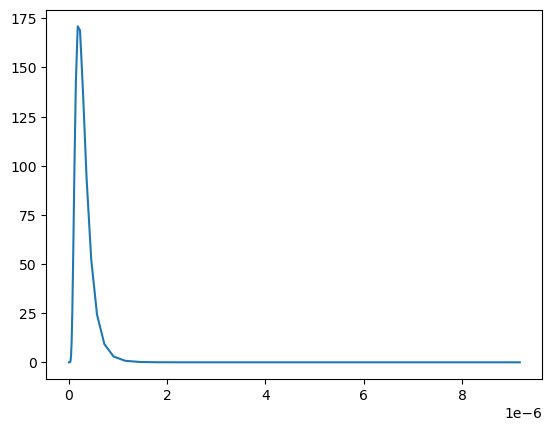

In [84]:
# plot the distribution
plt.plot(Dp, N)

In [85]:


result = simulation_general_dynamic_equation(
            bins_lower_sim_gde = bins_generator_dp_lower(bins_number=bin_number, d_p_min=dp_min, d_p_max=dp_max),
            bins_geom_mean_sim_gde = bins_generator_dp_g_mean(bins_number=bin_number, d_p_min=dp_min, d_p_max=dp_max),
            initial_mass_in_bins=np.ones(bin_number)*1e-10, # in kg
            time_step_size=1, # in seconds
            time_end=3600, # in seconds
            c_inf=1E6, # in molec/m^3
            c_sat=1E9, # in molec/m^3
            diff_coefficient=1E-9, # in m^2/s
            rho_p=1E3, # in kg/m^3
            temperature_sim_gde =273.15 + 25, 
            pressure_sim_gde=101325, 
            coagulation=False,
            condensation=True
            )

print(result)

ic| number_par_in_bins_all[0, :]: array([5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05, 5.75882382e-05, 5.75882382e-05, 5.75882382e-05,
                                         5.75882382e-05

KeyboardInterrupt: 

In [ ]:
result

In [ ]:


bins_lower = bins_generator_dp_lower(bin_number, dp_min, dp_max)
bins_upper = bins_generator_dp_upper(bin_number, dp_min, dp_max)
bins_geom_mean_sim_gde = bins_generator_dp_g_mean(bin_number, dp_min, dp_max)